### 上一节课我们搭建CNN网络对CIFAR数据集进行分类任务，得到了初步的效果，很可惜，不太好。本节课，我们看一下我们还能做什么？

### 准备数据集

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import datasets

In [2]:
print(tf.__version__)

2.11.0


In [3]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from PIL import Image
import numpy as np

In [5]:
#(x_train,y_train),(x_test,y_test) = datasets.cifar10.load_data()


### 本地读取数据集http://www.cs.toronto.edu/~kriz/cifar.html

In [6]:
#在给定数据文件中读取图片数据出来。
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
#创建训练样本和测试样本
def CreatData():
    #创建训练样本
    #依次加载batch_data_i,并合并到x,y
    x=[]
    y=[]
    for i in range(1,6):
        batch_path='cifar-10-batches-py/data_batch_%d'%(i)##/kaggle/input/cifar10batchespy/##'cifar_dataset/data_batch_%d'%(i)
        print(batch_path)
        batch_dict=unpickle(batch_path)
        print("unzip")
        train_batch=batch_dict[b'data'].astype('float')
        train_labels=np.array(batch_dict[b'labels'])
        x.append(train_batch)
        y.append(train_labels)
    print("hello")
    #将5个训练样本batch合并为50000x3072，标签合并为50000x1
    #np.concatenate默认axis=0，为纵向连接
    traindata=np.concatenate(x)
    trainlabels=np.concatenate(y)
    
    #创建测试样本
    #直接写cifar-10-batches-py\test_batch会报错，因此把/t当作制表符了，应用\\;
    #    test_dict=unpickle("cifar-10-batches-py\\test_batch")
    
    #建议使用os.path.join()函数
    testpath=os.path.join('cifar-10-batches-py','test_batch')
    print(testpath)
    test_dict=unpickle(testpath)
    testdata=test_dict[b'data'].astype('float')
    testlabels=np.array(test_dict[b'labels'])

    return traindata,trainlabels,testdata,testlabels
traindata,trainlabels,testdata,testlabels = CreatData()

cifar-10-batches-py/data_batch_1
unzip
cifar-10-batches-py/data_batch_2
unzip
cifar-10-batches-py/data_batch_3
unzip
cifar-10-batches-py/data_batch_4
unzip
cifar-10-batches-py/data_batch_5
unzip
hello
cifar-10-batches-py\test_batch


In [8]:
print(traindata.max())#通过最大值可以看到图片数据的格式和最大值。以便于调整使用imshow显示
print('train size is :',traindata.shape)
print('train_labels size is :',trainlabels.shape)
print('test size is :',testdata.shape)
print('test_labels size is :',testlabels.shape)

255.0
train size is : (50000, 3072)
train_labels size is : (50000,)
test size is : (10000, 3072)
test_labels size is : (10000,)


#### 我们可以看到训练集里面有5万张，测试集有1万，大小是32x32x3.然后标签是一维数据

In [9]:
#合并数据集为了后面的乱序
train_test = np.concatenate((traindata,testdata),axis=0)
print(train_test.shape)
train_test_label = np.concatenate((trainlabels,testlabels),axis=0)
train_test_label.shape

(60000, 3072)


(60000,)

In [10]:
import sklearn as sk#打乱数组和标签的顺序
x,y = sk.utils.shuffle(train_test,train_test_label,random_state=1)

#### 数据处理：1）归一化  2）one hot encoding

In [11]:
#数据归一化
x_guiyi = x.astype('float32')/255
#做one hot encoding
y_onehot = tf.keras.utils.to_categorical(y)

#### 在上面的test集读取，reshshape和显示的时候，我们注意到了:
#### 1.数据的存储矩阵为【3，32，32】，所以我们根据上面的操作，重新操作训练集。

In [12]:
x_images = np.reshape(x_guiyi, (x_guiyi.shape[0],3, 32, 32))

### 调整数组格式为50000，32，32，3.使用transpose函数，参考test数据集时候的矩阵转置方法。

In [13]:
x_images_images = np.transpose(x_images,(0,2,3,1)) # 读取image

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


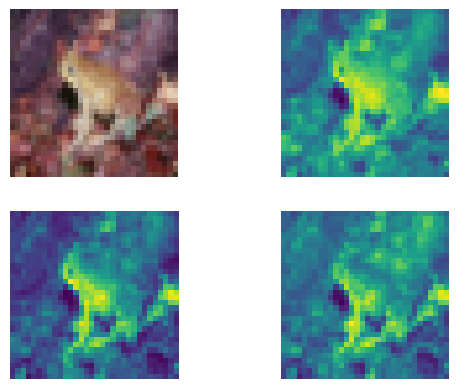

In [14]:
plt.figure()
plt.subplot(2,2,1)
plt.imshow(x_images_images[1])
plt.axis('off')


plt.subplot(2,2,2)
plt.imshow(x_images_images[1][:,:,0])
plt.axis('off')


plt.subplot(2,2,3)
plt.imshow(x_images_images[1][:,:,1])#(x_train_images[1].astype('uint8')[:,:,1])
plt.axis('off')


plt.subplot(2,2,4)
plt.imshow(x_images_images[1][:,:,2])
plt.axis('off')
print(y_onehot[1])

In [15]:
print(x_images_images.shape,y_onehot.shape)

(60000, 32, 32, 3) (60000, 10)


## 至此，我们的数据集如下：
### x_images_images----(60000, 32, 32, 3),取值范围0-1.
###        y_onehot----(60000,10)
### 为了减少模型运行时间以观察效果，我们做了两个事情，1）我们缩减了数据集，每个类别里面抽取300张图片。最终数据集为3000张图片。2）3D变2D灰度图像（可以不做）

In [16]:
## 学习list的基本操作
test_list = [[j for j in range(1)] for i in range(10)]
print(test_list)
print("----------------")
test_list[0].append(1)
print(test_list)
print("----------------")
test_list[0].pop()
print(test_list)
print("----------------")
test_list[0].pop()
print(test_list)
print("----------------")

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
----------------
[[0, 1], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
----------------
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
----------------
[[], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
----------------


In [17]:
def suojian(data,label, num):#data是需要被缩减的数据，label是对应data的标签，num是每个列别需要保留的个数
    class_label = [[j for j in range(1)] for i in range(10)]
    for i in range(10):
       # print(i)
        class_label[i].pop()#存储每个类别的索引
    for i in range(label.shape[0]):
        class_label[np.argmax(label[i])].append(i)
    #print(class_label)二维list，一维表示10个分类，一个维度记录着每个分类的图片所在下标
    #print(class_label[0][0:10])
    baoliu = []
    for i in range(10):
        temp = class_label[i][num:]
        #print(len(temp))
        baoliu.extend(temp)
    print(len(baoliu))
    #print(baoliu,len(baoliu))
    label1 =  np.delete(label,baoliu,axis=0)
    data1 = np.delete(data,baoliu,axis=0)
    x,y = sk.utils.shuffle(data1,label1,random_state=1)
    #print(data.shape,data1.shape)
    #print(label.shape,label1.shape)
    return x,y

In [18]:
suojian_x_images_images,suojian_y_onehot = suojian(x_images_images,y_onehot, 300)  #x_test_images,y_test #suojian(x_test_images,y_test, 5)
print('suojian totol images is :',suojian_x_images_images.shape)
print('suojian totol labels size is :',suojian_y_onehot.shape)

57000
suojian totol images is : (3000, 32, 32, 3)
suojian totol labels size is : (3000, 10)


### 拆分训练集/验证机/测试集，比例为8：1：1，也就是2400/300/300个。

In [19]:
# 观察过拟合现象.1)拆分数据集
def train_val_test(train_images,train_labels,ratio):
    num = train_images.shape[0] #总的数据集个数
    split_num_train = num - 2*round(num*ratio)
    split_num_val = num - round(num*ratio)
#拆分数据集和验证集
    train = train_images[:split_num_train]
    val = train_images[split_num_train:split_num_val]
    test = train_images[split_num_val:]
#拆分数据集和验证集标签    
    train_label = train_labels[:split_num_train]
    val_label = train_labels[split_num_train:split_num_val]
    test_label = train_labels[split_num_val:]

    return (train,train_label,val,val_label,test,test_label)

In [20]:

(sj_train,sj_train_label,sj_val,sj_val_label,sj_test,sj_test_label) = train_val_test(suojian_x_images_images,suojian_y_onehot,0.1)
print('suojian train images is :',sj_train.shape)
print('suojian train labels size is :',sj_train_label.shape)
print('suojian val images is :',sj_val.shape)
print('suojian val labels size is :',sj_val_label.shape)
print('suojian test images is :',sj_test.shape)
print('suojian test labels size is :',sj_test_label.shape)

suojian train images is : (2400, 32, 32, 3)
suojian train labels size is : (2400, 10)
suojian val images is : (300, 32, 32, 3)
suojian val labels size is : (300, 10)
suojian test images is : (300, 32, 32, 3)
suojian test labels size is : (300, 10)


In [21]:
#### 搭建模型

In [22]:
input_shape = (32,32,3)
model = Sequential()
model.add(Conv2D(8, kernel_size=(5,5),activation='sigmoid',padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Conv2D(16,kernel_size=(5,5),activation='sigmoid',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Flatten())
model.add(Dense(units=10,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 10)                1

In [23]:
model.compile(loss = 'mse', optimizer = optimizers.SGD(),metrics = ['accuracy'])  

In [24]:
print(sj_train.shape,sj_train_label.shape)

(2400, 32, 32, 3) (2400, 10)


In [25]:
model.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=1)

Epoch 1/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0964 - accuracy: 0.0958
Epoch 2/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0875
Epoch 3/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0846
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0954
Epoch 5/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0971
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0958
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0925
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0867
Epoch 9/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0929
Epoch 10/10
600/600 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.0958

In [26]:
model.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 [==============================] - 0s 3ms/step - loss: 0.0901 - accuracy: 0.0933


[0.0901045948266983, 0.09333333373069763]

### 模型性能提升：1）优化器。2）激活函数。3）损失函数.4）过拟合。5）数据增强。

####  1)优化器 Adam虽然可以自动调整学习率，可是初始学习率过大，很可能直接收敛到很差的局部最小值点，而后面的学习因为学习率已经被降低，就再也跳不出去了。所以不宜过大。一般的框架中，默认学习率1e-3。

In [27]:
#优化器,参考链接https://zhuanlan.zhihu.com/p/378629475优化器不同,收敛速度和效果会有不同,具体模型表现不一样,是一个尝试调参的过程.
model2 = Sequential()
model2.add(Conv2D(8, kernel_size=(5,5),activation='sigmoid',padding='same', input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2,2), strides=2))
model2.add(Conv2D(16,kernel_size=(5,5),activation='sigmoid',padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2), strides=2))
model2.add(Flatten())
model2.add(Dense(units=10,activation='sigmoid'))
model2.summary()
#优化器改为ADAM
model2.compile(loss = 'mse', optimizer = optimizers.Adam(0.001),metrics = ['accuracy'])  
model2.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)               

In [28]:
model2.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 [==============================] - 0s 3ms/step - loss: 0.0805 - accuracy: 0.3367


[0.08050853759050369, 0.33666667342185974]

#### 2)激活函数 之sigmoid--softmax

In [29]:
#sigmoid ---- softmax
model3 = Sequential()
model3.add(Conv2D(8, kernel_size=(5,5),activation='softmax',padding='same', input_shape=input_shape))
model3.add(MaxPooling2D(pool_size=(2,2), strides=2))
model3.add(Conv2D(16,kernel_size=(5,5),activation='softmax',padding='same'))
model3.add(MaxPooling2D(pool_size=(2,2), strides=2))
model3.add(Flatten())
model3.add(Dense(units=10,activation='softmax'))
model3.summary()
#优化器改为ADAM
model3.compile(loss = 'mse', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
model3.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 10)               

In [30]:
model3.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 [==============================] - 0s 4ms/step - loss: 0.0752 - accuracy: 0.3933


[0.07521618902683258, 0.3933333456516266]

In [31]:
##softmax 函数返回值测试验证代码。可省略
#xp = model3.predict(suojian_x_test_images_2d)
#j=0
#for i in range(len(suojian_x_test_images_2d)):
    #tem = np.argmax(xp[i])
    #print(tem)
    #if (tem == np.argmax(suojian_y_test[i])): 
       # j = j+1
#print(j/len(suojian_x_test_images_2d))  

### 2)激活函数之 relu,该函数解决部分梯度弥散问题,收敛速度更快

In [32]:
#激活函数,relu使用,解决部分梯度弥散问题,收敛速度更快
model4 = Sequential()
model4.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model4.add(MaxPooling2D(pool_size=(2,2), strides=2))
model4.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model4.add(MaxPooling2D(pool_size=(2,2), strides=2))
model4.add(Flatten())
model4.add(Dense(units=10,activation='softmax'))
model4.summary()
#优化器改为ADAM
model4.compile(loss = 'mse', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
model4.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 10)               

In [33]:
model4.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 [==============================] - 0s 3ms/step - loss: 0.0795 - accuracy: 0.4167


[0.07953457534313202, 0.4166666567325592]

### 2)激活函数之 tanh,该函数解决原点对称问题

In [34]:
#激活函数,换成tanh,我们观察到底是tanh还是relu对当前情况来说,更为合适?
model5 = Sequential()
model5.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model5.add(MaxPooling2D(pool_size=(2,2), strides=2))
model5.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model5.add(MaxPooling2D(pool_size=(2,2), strides=2))
model5.add(Flatten())
model5.add(Dense(units=10,activation='tanh'))
model5.summary()
#优化器改为ADAM
model5.compile(loss = 'mse', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
model5.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 10)               

In [35]:
model5.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 [==============================] - 0s 3ms/step - loss: 0.0843 - accuracy: 0.3967


[0.08428946137428284, 0.39666667580604553]

### 总结,我们发现relu加tanh，要比relu+softmax更适合我们当前的场景.
## 请尝试一下所有激活函数是tanh的情况，会更好吗？

### 3)损失函数---交叉熵

In [36]:
#使用当前表变现优秀的relu激活函数，调整损失函数为交叉熵函数。
model6 = Sequential()
model6.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model6.add(MaxPooling2D(pool_size=(2,2), strides=2))
model6.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model6.add(MaxPooling2D(pool_size=(2,2), strides=2))
model6.add(Flatten())
model6.add(Dense(units=10,activation='softmax'))
model6.summary()
#优化器改为ADAM
model6.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
model6.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 10)               

In [37]:
model6.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 [==============================] - 0s 3ms/step - loss: 1.7788 - accuracy: 0.4733


[1.7787870168685913, 0.47333332896232605]

### 交叉熵于mse好，relu是目前表现比较好的激活函数，另外relu+tanh+mse的方式也还不错。

### 另外我们注意到,训练结果一直上升,但是为什么模型评估函数输出的结果不仅人意呢?此时我们应该关注过拟合或者欠拟合现象.
### 过拟合或者欠拟合现象的发现需要在fit的时候设置验证集合,也就是需要把训练集的一部分(通常20%)设置为验证集.
### 过拟合的解决,有三种方法1)正则.2)dropout.3)增强数据集。欠拟合需要增加训练次数，同样可以通过解决过拟合来缓解模型的欠拟合

### 4）观察过拟合现象,利用曲线绘制epoch和train和val数据集的关系

In [38]:
#########画图,用来显示每个epoch，训练集和验证集的走向
def loss_acc_curve(history):
    print(history.history.keys())
    acc = history.history['accuracy']  #获取训练集准确性数据
    val_acc = history.history['val_accuracy'] #获取验证集准确性数据
    loss = history.history['loss']   #获取训练集错误值数据
    val_loss = history.history['val_loss'] #获取验证集错误值数据
    epochs = range(1,len(acc)+1)
    #plt.subplot(121)
    plt.plot(epochs,acc,'bo',label='Trainning acc')  #以epochs为横坐标，以训练集准确性为纵坐标
    plt.plot(epochs,val_acc,'b',label='Vaildation acc') #以epochs为横坐标，以验证集准确性为纵坐标
    plt.legend() #绘制图例，即标明图中的线段代表何种含义

   # plt.subplot(122)
    plt.figure()
    plt.plot(epochs,loss,'bo',label='Trainning loss')
    plt.plot(epochs,val_loss,'b',label='Vaildation loss')
    plt.legend() ##绘制图例，即标明图中的线段代表何种含义

In [39]:
# 添加验证集，绘制曲线，观察过拟合现象
model7 = Sequential()
model7.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model7.add(MaxPooling2D(pool_size=(2,2), strides=2))
model7.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model7.add(MaxPooling2D(pool_size=(2,2), strides=2))
model7.add(Flatten())
model7.add(Dense(units=10,activation='softmax'))
model7.summary()
#优化器改为ADAM
model7.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
history7 = model7.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=20,verbose=1)
#model.fit 中的 verbose
#verbose：日志显示
#verbose = 0 为不在标准输出流输出日志信息
#verbose = 1 为输出进度条记录
#verbose = 2 为每个epoch输出一行记录
#注意： 默认为 1

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 10)               

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


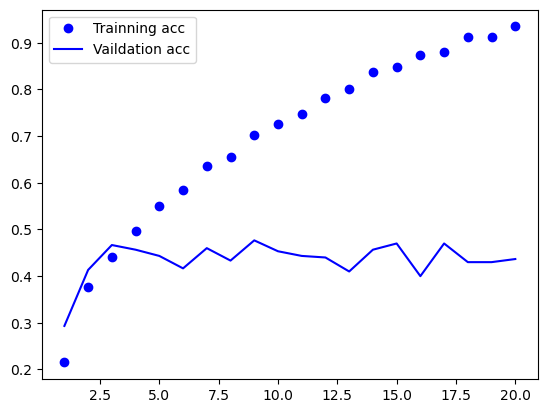

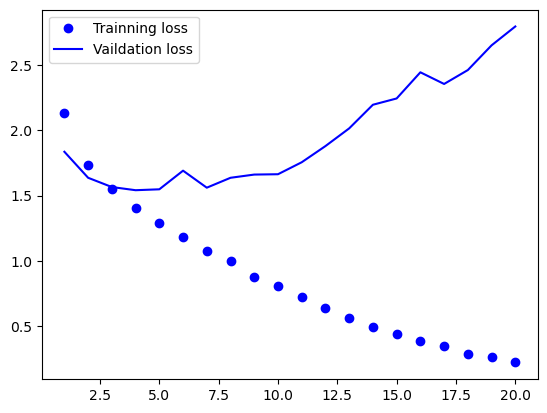

In [40]:
loss_acc_curve(history7)

In [41]:
model7.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 [==============================] - 0s 3ms/step - loss: 3.2763 - accuracy: 0.4067


[3.2762556076049805, 0.40666666626930237]

## 总结：大概第8次左右出现过拟合现象

### 在图上我们看到验证集loss曲线在第7次的时候立马上升，我们发现模型对于数据集来说存在严重的过拟合现象。
### 过拟合的解决,有三种方法1)正则.2)dropout.3)增强数据集.4)简单化模型结构

In [42]:
# 添加dropout
model8 = Sequential()
model8.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model8.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model8.add(Dropout(0.2))
model8.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model8.add(MaxPooling2D(pool_size=(2,2), strides=2))
model8.add(Dropout(0.2))
model8.add(Flatten())
model8.add(Dense(units=10,activation='softmax'))
model8.summary()
#优化器改为ADAM
model8.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
history8 = model8.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=20,verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 8, 8, 16)          0         
                                                                 
 flatten_7 (Flatten)         (None, 1024)             

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
10/10 [==============================] - 0s 3ms/step - loss: 2.0620 - accuracy: 0.4333


[2.062006950378418, 0.4333333373069763]

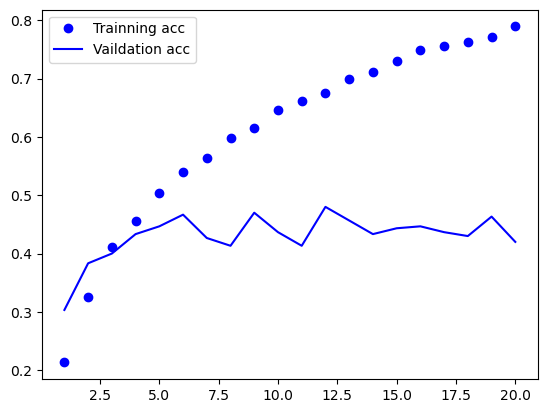

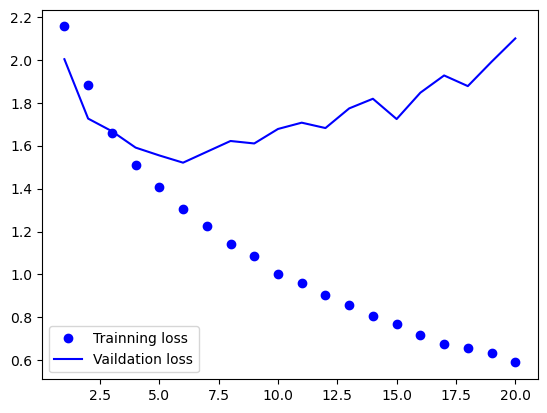

In [43]:
loss_acc_curve(history8)
model8.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### 总结：添加Dropout以后，模型的过拟合现象有所减轻，验证loss大概在12次左右产生

In [44]:
# 添加正则,还可以使用tf.keras.regularizers.L1()来查看模型的效果
model9 = Sequential()
model9.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model9.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model9.add(Dropout(0.2))
model9.add(Conv2D(16,kernel_size=(5,5),activation='relu',kernel_regularizer = tf.keras.regularizers.L2(),padding='same'))
model9.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model8.add(Dropout(0.2))
model9.add(Flatten())
model9.add(Dense(units=10,activation='softmax'))
model9.summary()
#优化器改为ADAM
model9.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])  #categorical_crossentropy
history9 = model9.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=15,verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 10)               

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
10/10 [==============================] - 0s 3ms/step - loss: 1.8055 - accuracy: 0.4600


[1.8055305480957031, 0.46000000834465027]

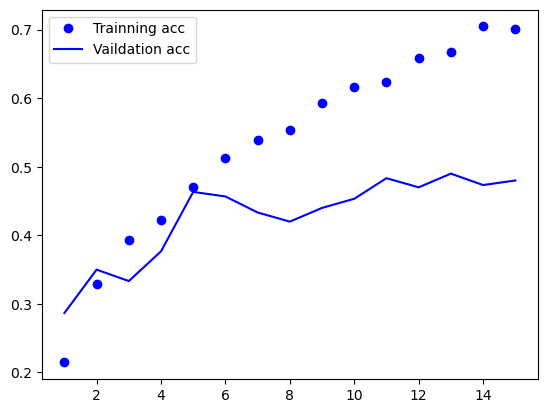

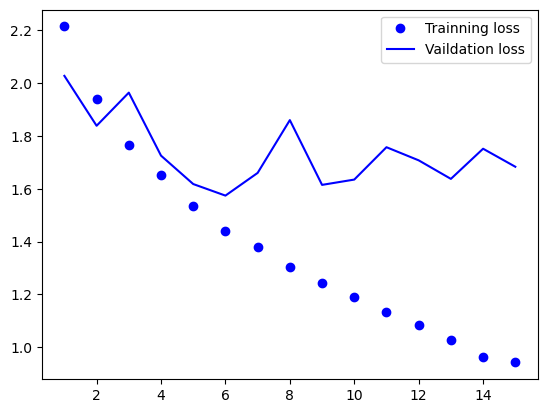

In [45]:
loss_acc_curve(history9)
model9.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

In [46]:
# 添加正则,还可以使用tf.keras.regularizers.L1()来查看模型的效果
model9_1 = Sequential()
model9_1.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model9_1.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model9.add(Dropout(0.2))
model9_1.add(Conv2D(16,kernel_size=(5,5),activation='relu',kernel_regularizer = tf.keras.regularizers.L1(),padding='same'))
model9_1.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model8.add(Dropout(0.2))
model9_1.add(Flatten())
model9_1.add(Dense(units=10,activation='softmax'))
model9_1.summary()
#优化器改为ADAM
model9_1.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
history9_1 = model9_1.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=20,verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 10)               

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
10/10 [==============================] - 0s 3ms/step - loss: 1.8752 - accuracy: 0.3733


[1.875247597694397, 0.3733333349227905]

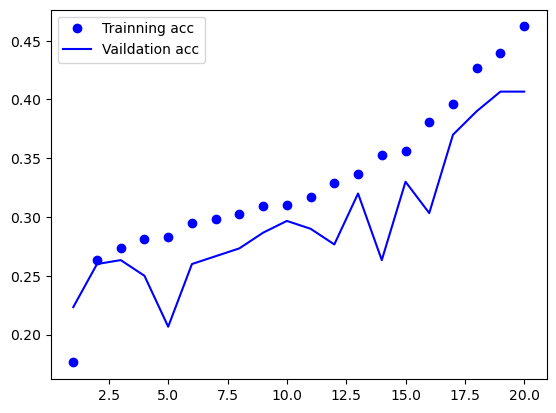

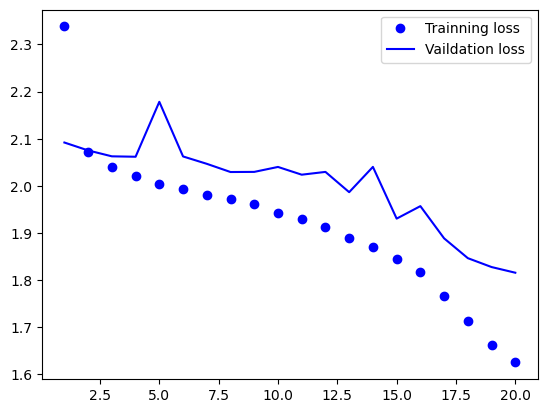

In [47]:
loss_acc_curve(history9_1)
model9_1.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### L2正则，过拟合在10次左右。使用L1正则，大概在20次左右，下面我们来验证下，联合使用正则和Dropout的效果

In [48]:
# 添加正则和dropout
model10 = Sequential()
model10.add(Conv2D(8, kernel_size=(5,5),activation='relu',kernel_regularizer = tf.keras.regularizers.L1(),padding='same', input_shape=input_shape))
model10.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model9.add(Dropout(0.2))
model10.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model10.add(MaxPooling2D(pool_size=(2,2), strides=2))
model10.add(Dropout(0.2))
model10.add(Flatten())
model10.add(Dense(units=10,activation='softmax'))
model10.summary()
#优化器改为ADAM
model10.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
history10 = model10.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=40,verbose=1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 16)          0         
                                                                 
 flatten_10 (Flatten)        (None, 1024)            

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
10/10 [==============================] - 0s 3ms/step - loss: 2.0886 - accuracy: 0.4667


[2.0885579586029053, 0.46666666865348816]

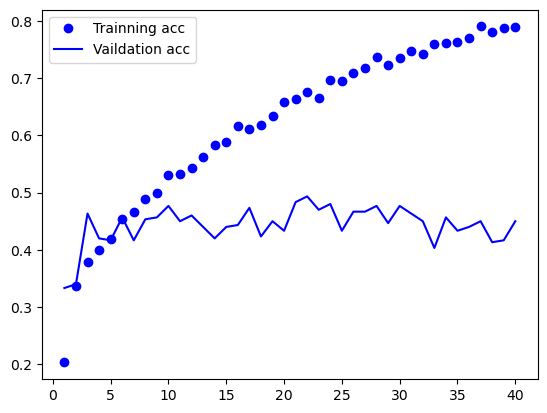

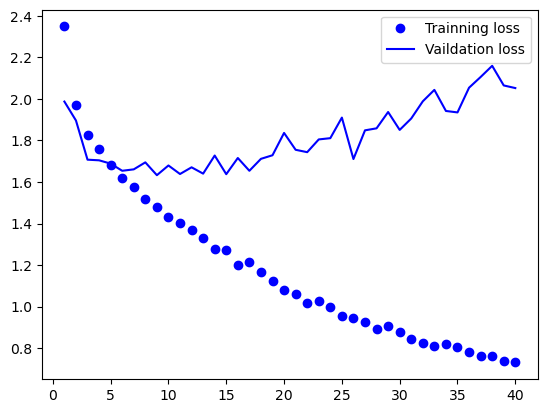

In [49]:
loss_acc_curve(history10)
model10.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

In [50]:
# 添加正则和dropout
model11 = Sequential()
model11.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model11.add(MaxPooling2D(pool_size=(2,2), strides=2))
model11.add(Dropout(0.2))
model11.add(Conv2D(16,kernel_size=(5,5),activation='relu',kernel_regularizer = tf.keras.regularizers.L1(),padding='same'))
model11.add(MaxPooling2D(pool_size=(2,2), strides=2))
model11.add(Dropout(0.2))
model11.add(Flatten())
model11.add(Dense(units=10,activation='softmax'))
model11.summary()
#优化器改为ADAM
model11.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
history11 = model11.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=40,verbose=1)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 8)         0         
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 16)        

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
10/10 [==============================] - 0s 3ms/step - loss: 1.7723 - accuracy: 0.4100


[1.772274374961853, 0.4099999964237213]

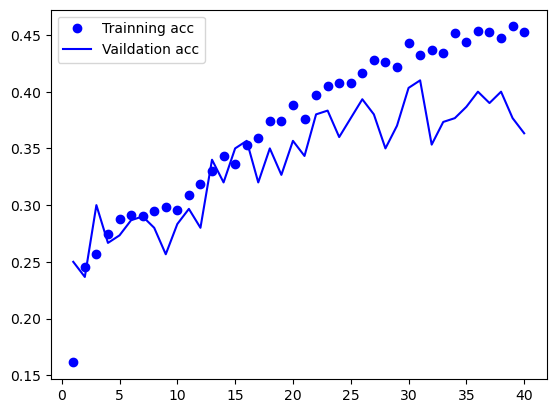

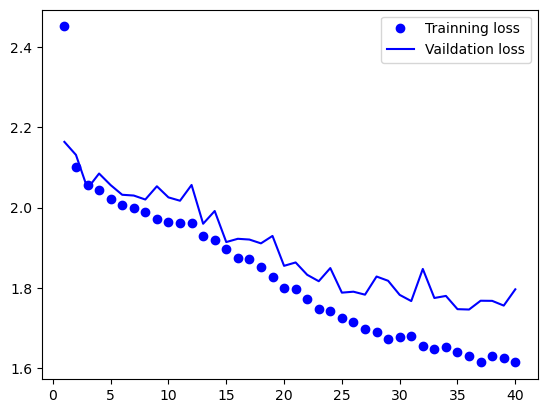

In [51]:
loss_acc_curve(history11)
model11.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### 太多的降低参数个数，模型过拟合会降低，但是对应的是模型准确率的震荡和下降

In [52]:
#两个Dropout函数
model12 = Sequential()
model12.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model12.add(MaxPooling2D(pool_size=(2,2), strides=2))
model12.add(Dropout(0.2))
model12.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model12.add(MaxPooling2D(pool_size=(2,2), strides=2))
model12.add(Dropout(0.2))
model12.add(Flatten())
model12.add(Dense(units=10,activation='softmax'))
model12.summary()
#优化器改为ADAM
model12.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
history12 = model12.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=35,verbose=1)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 8)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 16)        

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
10/10 [==============================] - 0s 3ms/step - loss: 1.9517 - accuracy: 0.4433


[1.9516812562942505, 0.44333332777023315]

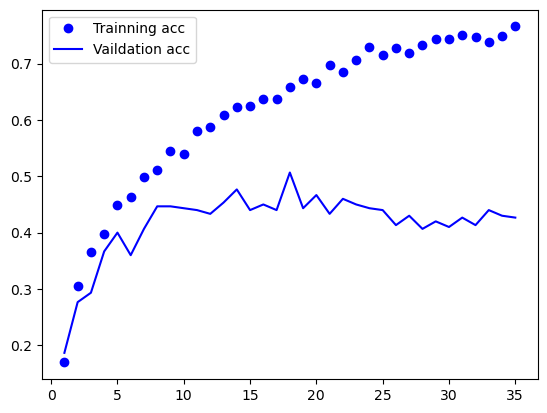

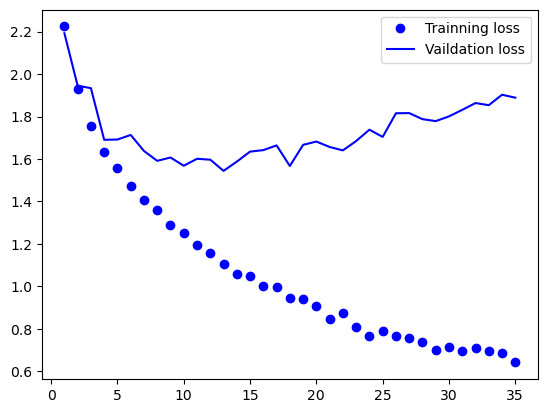

In [53]:
loss_acc_curve(history12)
model12.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### 总结：第一个卷积添加L1正则，在之后添加dropout，是当前环境下，准确率和抑制过拟合比较合适的选择。
### 扩增数据集能减轻过拟合现象,表现为验证集和训练集的曲线更为接近，我们利用缩减函数得到我们想要的3000个数据集，然后利用分割函数分为训练/测试/验证三个集合
### suojian_x_images_images,suojian_y_onehot = suojian(x_images_images,y_onehot, 300)  #x_test_images,y_test #### 
### suojian(x_test_images,y_test, 5)
### print('suojian totol images is :',suojian_x_images_images.shape)
### print('suojian totol labels size is :',suojian_y_onehot.shape)

In [54]:
suojian_x_images_images_v2,suojian_y_onehot_v2 = suojian(x_images_images,y_onehot, 600)  #x_test_images,y_test #suojian(x_test_images,y_test, 5)
print('suojian totol images is :',suojian_x_images_images_v2.shape)
print('suojian totol labels size is :',suojian_y_onehot_v2.shape)

54000
suojian totol images is : (6000, 32, 32, 3)
suojian totol labels size is : (6000, 10)


In [55]:
(sj_train_2,sj_train_label_2,sj_val_2,sj_val_label_2,sj_test_2,sj_test_label_2) = train_val_test(suojian_x_images_images_v2,suojian_y_onehot_v2,0.1)
print('suojian train images is :',sj_train_2.shape)
print('suojian train labels size is :',sj_train_label_2.shape)
print('suojian val images is :',sj_val_2.shape)
print('suojian val labels size is :',sj_val_label_2.shape)
print('suojian test images is :',sj_test_2.shape)
print('suojian test labels size is :',sj_test_label_2.shape)

suojian train images is : (4800, 32, 32, 3)
suojian train labels size is : (4800, 10)
suojian val images is : (600, 32, 32, 3)
suojian val labels size is : (600, 10)
suojian test images is : (600, 32, 32, 3)
suojian test labels size is : (600, 10)


In [56]:
model13 = Sequential()
model13.add(Conv2D(8, kernel_size=(5,5),activation='relu',kernel_regularizer = tf.keras.regularizers.L1(),padding='same', input_shape=input_shape))
model13.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model13.add(Dropout(0.2))
model13.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model13.add(MaxPooling2D(pool_size=(2,2), strides=2))
model13.add(Dropout(0.2))
model13.add(Flatten())
model13.add(Dense(units=10,activation='softmax'))
model13.summary()
#优化器改为ADAM
model13.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
history13 = model13.fit(sj_train_2,sj_train_label_2,validation_data=(sj_val_2,sj_val_label_2),batch_size=4,epochs=40,verbose=1)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 16)          0         
                                                                 
 flatten_13 (Flatten)        (None, 1024)            

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
19/19 [==============================] - 0s 3ms/step - loss: 1.6137 - accuracy: 0.5383


[1.6136555671691895, 0.5383333563804626]

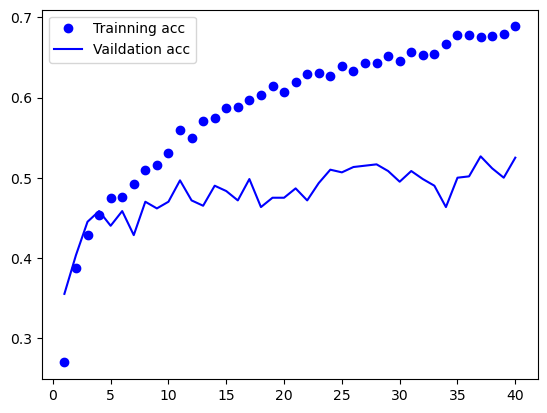

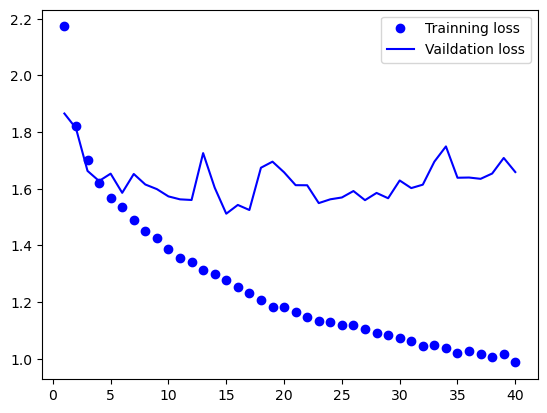

In [57]:
loss_acc_curve(history13)
model13.evaluate(sj_test_2,sj_test_label_2) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### 总结，1）增加数据集，可以把在模型优化基础上,减轻过拟合现象，让模型准确率有轻微的提升。
###   2）同时我们应该意识到，我们epoch=40并不是模型最佳点，也就是说训练到40次的时候，模型性能并不太好，看上图，也许在epoch=15左右的时候也许最佳。

### 4)简单化模型,过拟合现象可以降低

In [58]:
#减少卷积核个数,缩小卷积核尺寸,减少模型复杂度,可以缓解过拟合现象,提高准确率
#卷积核个数是提取特征,因此缩小尺寸比直接减少卷积核个数要更为合适一些,但是也需要实验才能根据自己的数据情况来决定
model14 = Sequential()
model14.add(Conv2D(8, kernel_size=(3,3),activation='relu',kernel_regularizer = tf.keras.regularizers.L1(),padding='same', input_shape=input_shape))
model14.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model14.add(Dropout(0.2))
model14.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
model14.add(MaxPooling2D(pool_size=(2,2), strides=2))
model13.add(Dropout(0.2))
model14.add(Flatten())
model14.add(Dense(units=10,activation='softmax'))
model14.summary()
#优化器改为ADAM
model14.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
history14 = model14.fit(sj_train_2,sj_train_label_2,validation_data=(sj_val_2,sj_val_label_2),batch_size=4,epochs=20,verbose=1)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 10)              

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
19/19 [==============================] - 0s 3ms/step - loss: 1.5776 - accuracy: 0.5533


[1.5776287317276, 0.5533333420753479]

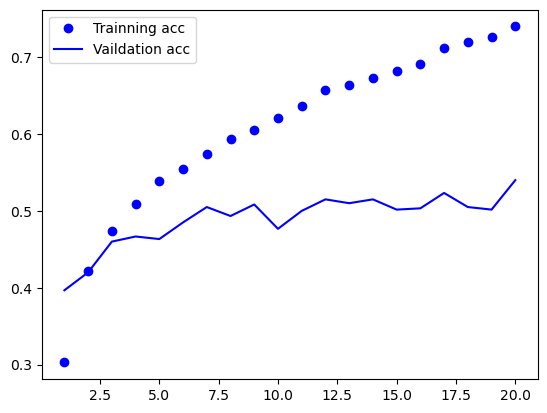

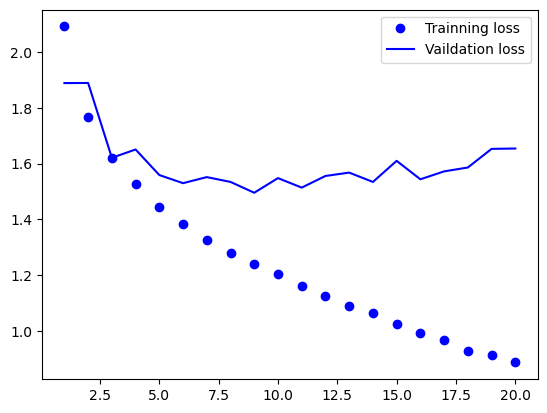

In [59]:
loss_acc_curve(history14)
model14.evaluate(sj_test_2,sj_test_label_2) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

 ### 我们在前面提到并不是epoch越大模型越好，那么什么时候模型最好呢？使用dropout+earlystopping,获取最佳模型
 ### 为了运行速度，我采用第一个版本的缩小数据集

In [60]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8)

In [61]:
model15 = Sequential()
model15.add(Conv2D(8, kernel_size=(3,3),activation='relu',kernel_regularizer = tf.keras.regularizers.L1(),padding='same', input_shape=input_shape))
model15.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model15.add(Dropout(0.2))
model15.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
model15.add(MaxPooling2D(pool_size=(2,2), strides=2))
model13.add(Dropout(0.2))
model15.add(Flatten())
model15.add(Dense(units=10,activation='softmax'))
model15.summary()
#优化器改为ADAM
model15.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])  
history15 = model15.fit(sj_train,sj_train_label,callbacks=[early_stop],validation_data=(sj_val,sj_val_label),batch_size=4,epochs=350,verbose=1)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 8, 8, 16)         0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 10)              

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
10/10 [==============================] - 0s 3ms/step - loss: 2.0177 - accuracy: 0.4333


[2.0177314281463623, 0.4333333373069763]

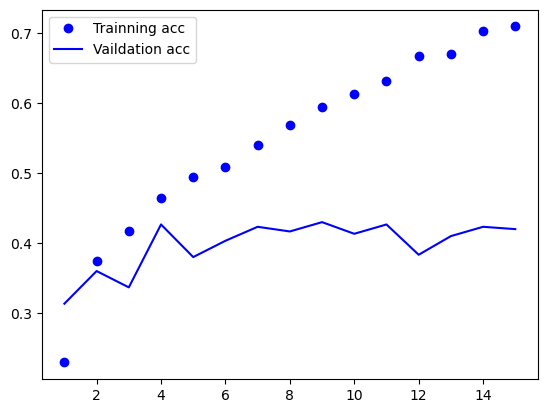

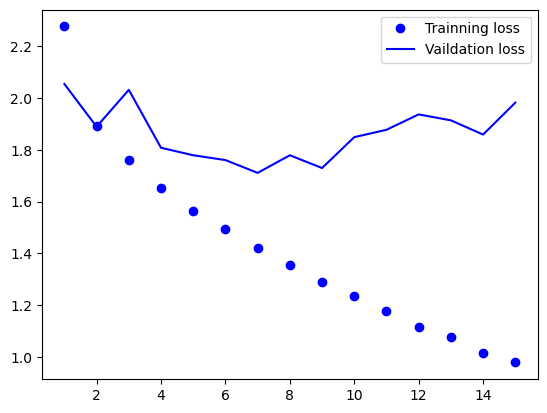

In [62]:
loss_acc_curve(history15)
model15.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### 总结：模型选择epoch合适的时候，较少数据集就可以达到较大数据集刚才测试的效果，当然较大数据集也可以通过选择最佳模型进一步提高准确率

### 全数据集参与训练，测试模型性能。

In [63]:
(sj_train_3,sj_train_label_3,sj_val_3,sj_val_label_3,sj_test_3,sj_test_label_3) = train_val_test(x_images_images,y_onehot,0.16)

In [64]:
print(sj_train_3.shape,sj_val_3.shape,sj_test_3.shape)
print(sj_train_label_3.shape,sj_val_label_3.shape,sj_test_label_3.shape)

(40800, 32, 32, 3) (9600, 32, 32, 3) (9600, 32, 32, 3)
(40800, 10) (9600, 10) (9600, 10)


In [65]:
sj_train_label_3[3]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [66]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)

In [67]:
#全部数据集参与训练
model16 = Sequential()
model16.add(Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=input_shape))
model16.add(MaxPooling2D(pool_size=(2,2), strides=2))
model16.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model16.add(MaxPooling2D(pool_size=(2,2), strides=2))
model16.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

model16.add(Flatten())
model16.add(Dense(units=64, activation='relu'))
model16.add(Dense(units=10, activation='softmax'))
model16.summary()
#优化器改为ADAM
model16.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(0.001),metrics = ['accuracy'])  
history16 = model16.fit(sj_train_3,sj_train_label_3,callbacks=[early_stop],validation_data=(sj_val_3,sj_val_label_3),batch_size=4,epochs=150,verbose=2)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_16 (Flatten)        (None, 1024)            

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
300/300 [==============================] - 1s 4ms/step - loss: 1.6719 - accuracy: 0.6196


[1.67192804813385, 0.6195833086967468]

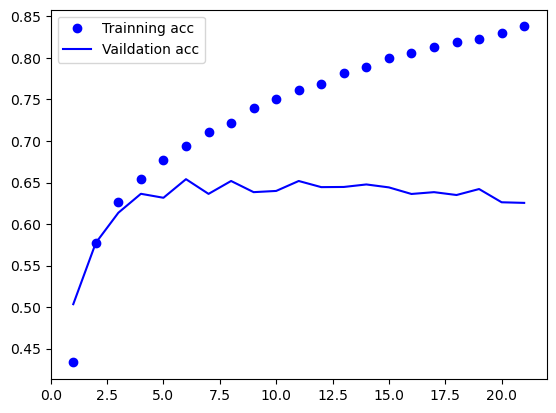

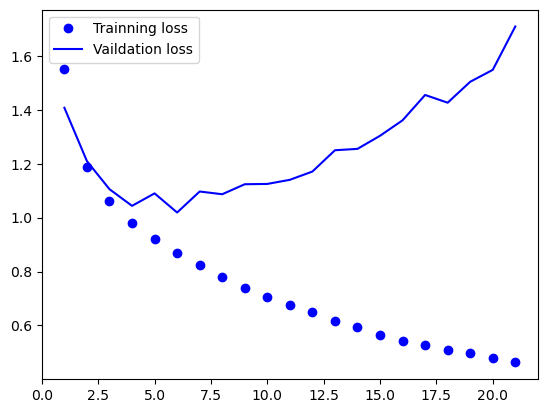

In [68]:
loss_acc_curve(history16)
model16.evaluate(sj_test_3,sj_test_label_3) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

In [69]:
early_stop1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)

In [70]:
#在上一个版本上面增加dropout
model17 = Sequential()
model17.add(Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=input_shape))
model17.add(MaxPooling2D(pool_size=(2,2), strides=2))
model17.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model17.add(MaxPooling2D(pool_size=(2,2), strides=2))
model17.add(Dropout(0.25))
model17.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model17.add(Dropout(0.2))
model17.add(Flatten())
model17.add(Dense(units=64, activation='relu'))
model17.add(Dense(units=10, activation='softmax'))
model17.summary()
#优化器改为ADAM
model17.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(0.001),metrics = ['accuracy'])  
history17 = model17.fit(sj_train_3,sj_train_label_3,callbacks=[early_stop1],validation_data=(sj_val_3,sj_val_label_3),batch_size=4,epochs=150,verbose=2)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 conv2d_37 (Conv2D)          (None, 4, 4, 64)        

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
300/300 [==============================] - 1s 4ms/step - loss: 0.9045 - accuracy: 0.7066


[0.9045477509498596, 0.7065625190734863]

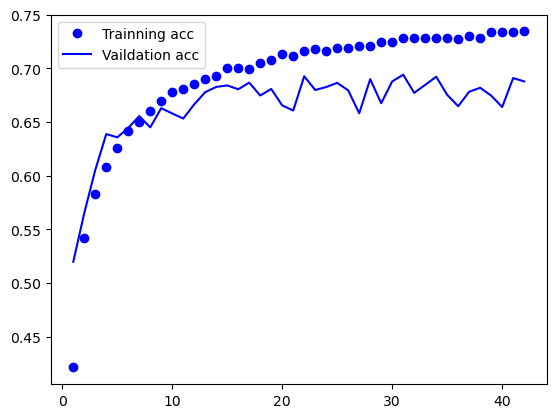

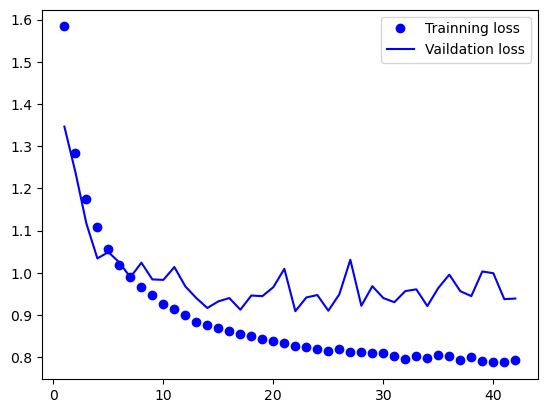

In [71]:
loss_acc_curve(history17)
model17.evaluate(sj_test_3,sj_test_label_3) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### 到此结束，你或许需要再仔细整理下思路。然后去完成作业吧